In [7]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
from tqdm import tqdm_notebook as tqdm
from PIL import Image
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
# from skimage.restoration import denoise_tv_bregman

MNIST_PATH = 'data/mnist'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


/home/pmahaja2/miniconda3/envs/ml/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
device

device(type='cuda')

In [9]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
    def get_fc1(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = MNISTModel().to(device)

In [227]:
class MNISTModel1(nn.Module):
    def __init__(self):
        super(MNISTModel1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        print(x.shape)
        x = F.relu(self.conv1(x))
        print(x.shape)
        x = F.relu(self.conv2(x))
        print(x.shape)
        x = x.view(-1, 320)
        print(x.shape)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
    def get_fc1(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model1 = MNISTModel1().to(device)
model1(torch.randn(10,1,28,28).to(device)).shape

torch.Size([10, 1, 28, 28])
torch.Size([10, 10, 12, 12])
torch.Size([10, 20, 4, 4])
torch.Size([10, 320])


torch.Size([10, 10])

In [10]:
def train(epoch, model, device, train_loader,optimizer, interval):
    losses = []
    correct = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader,leave=False)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses, correct / len(train_loader.dataset)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            test_loss += loss.item() # sum up batch loss
            losses.append(loss.item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return losses, correct / len(test_loader.dataset) 


In [11]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True, num_workers=8, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=False, num_workers=8, pin_memory=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


In [14]:
test(model, device, test_loader)[1]


Test set: Average loss: 0.0005, Accuracy: 9627/10000 (96%)



0.9627

In [13]:
train_loss = []
test_loss = []
accuracy_train = []
accuracy_test = []
for epoch in range(10):
    train_loss_current, accuracy_train_current = train(epoch, model, device, train_loader, optimizer, interval=235)
    test_loss_current, accuracy_test_current = test(model, device, test_loader)
    train_loss.append(np.mean(train_loss_current))
    test_loss.append(np.mean(test_loss_current))
    accuracy_train.append(accuracy_train_current)
    accuracy_test.append(accuracy_test_current)    

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314016



Test set: Average loss: 0.0019, Accuracy: 8572/10000 (86%)



Train Epoch: 1 [0/60000 (0%)]	Loss: 0.571376



Test set: Average loss: 0.0013, Accuracy: 9020/10000 (90%)



Train Epoch: 2 [0/60000 (0%)]	Loss: 0.290440



Test set: Average loss: 0.0011, Accuracy: 9151/10000 (92%)



Train Epoch: 3 [0/60000 (0%)]	Loss: 0.280822



Test set: Average loss: 0.0009, Accuracy: 9339/10000 (93%)



Train Epoch: 4 [0/60000 (0%)]	Loss: 0.285413



Test set: Average loss: 0.0007, Accuracy: 9444/10000 (94%)



Train Epoch: 5 [0/60000 (0%)]	Loss: 0.182876



Test set: Average loss: 0.0007, Accuracy: 9494/10000 (95%)



Train Epoch: 6 [0/60000 (0%)]	Loss: 0.223267



Test set: Average loss: 0.0007, Accuracy: 9503/10000 (95%)



Train Epoch: 7 [0/60000 (0%)]	Loss: 0.147263



Test set: Average loss: 0.0006, Accuracy: 9564/10000 (96%)



Train Epoch: 8 [0/60000 (0%)]	Loss: 0.158029



Test set: Average loss: 0.0006, Accuracy: 9500/10000 (95%)



Train Epoch: 9 [0/60000 (0%)]	Loss: 0.160164



Test set: Average loss: 0.0005, Accuracy: 9627/10000 (96%)



In [15]:
accuracy_test

[0.8572, 0.902, 0.9151, 0.9339, 0.9444, 0.9494, 0.9503, 0.9564, 0.95, 0.9627]

In [16]:
torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()

43

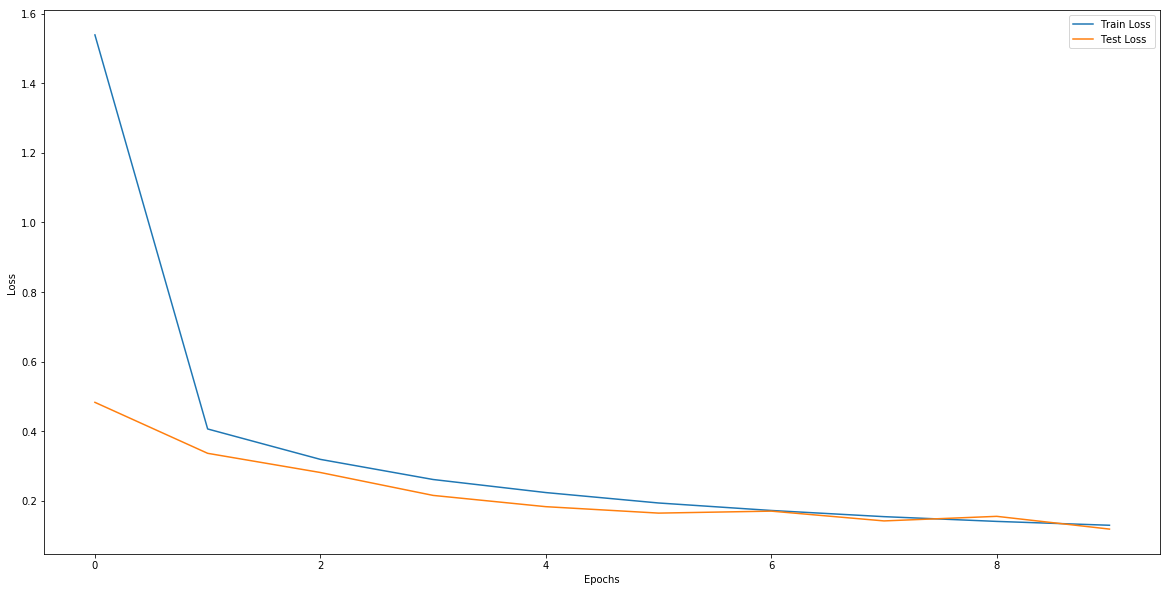

In [17]:
plt.figure(figsize=(20,10))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Text(0, 0.5, 'Accuracy')

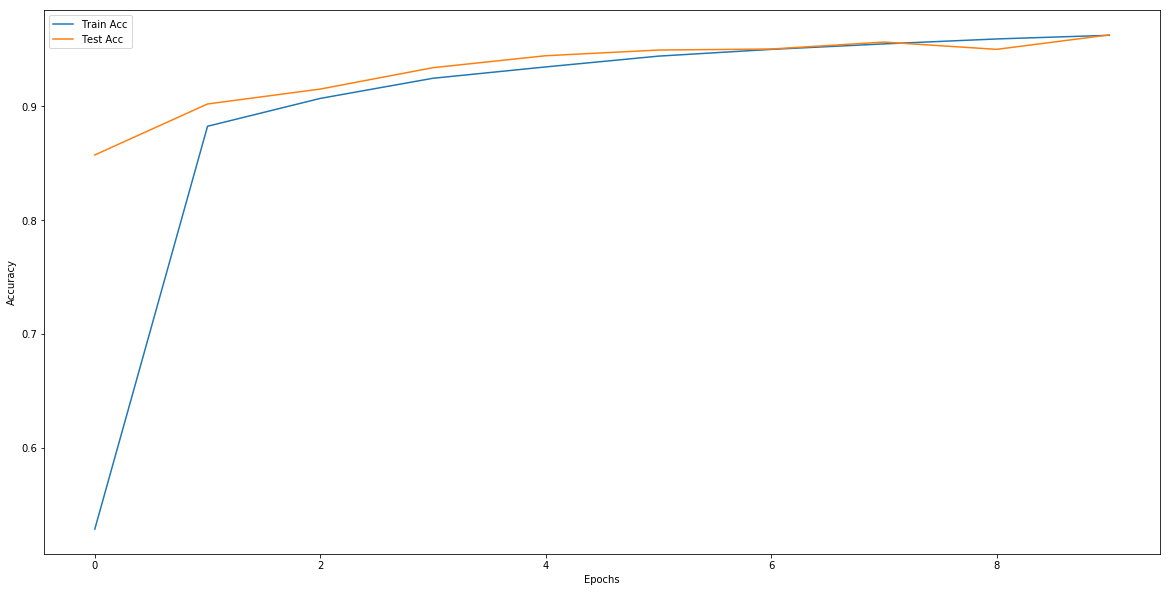

In [18]:
plt.figure(figsize=(20,10))
plt.plot(accuracy_train, label="Train Acc")
plt.plot(accuracy_test, label="Test Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [75]:
key_to_maximize = torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
torch.abs(model.fc1.weight).sum(dim=1)[key_to_maximize].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize
num_line[~mask]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 44., 45., 46., 47., 48., 49.])

<BarContainer object of 1 artists>

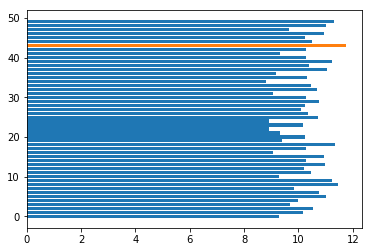

In [63]:
barh(num_line[~mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
barh(num_line[mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[mask])

In [64]:
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((28,28)))
    return im
def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:10] for curr_label in np.unique(labels)}
                break
        return label_digit

In [76]:
for key in model.state_dict():
    print(key, model.state_dict()[key].abs().argmax(), model.state_dict()[key].abs().max())

conv1.weight tensor(38, device='cuda:0') tensor(0.5394, device='cuda:0')
conv1.bias tensor(5, device='cuda:0') tensor(0.4794, device='cuda:0')
conv2.weight tensor(3288, device='cuda:0') tensor(0.2382, device='cuda:0')
conv2.bias tensor(4, device='cuda:0') tensor(0.0666, device='cuda:0')
fc1.weight tensor(13981, device='cuda:0') tensor(0.1450, device='cuda:0')
fc1.bias tensor(15, device='cuda:0') tensor(0.0694, device='cuda:0')
fc2.weight tensor(335, device='cuda:0') tensor(0.3547, device='cuda:0')
fc2.bias tensor(5, device='cuda:0') tensor(0.1391, device='cuda:0')


In [77]:
digit_to_data = get_label_and_inputs_dict(test_loader)
for i in range(10):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data[label_to_fetch].to(device)) 
    fc1_output = model.get_fc1(digit_to_data[label_to_fetch].to(device)) 
#     print(i, fc1_output.topk(2)[1])
    print(i, fc1_output.argmax(dim=1))

0 tensor([ 8, 13,  8,  8,  8,  8, 13, 13,  1, 13], device='cuda:0')
1 tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14], device='cuda:0')
2 tensor([17, 49, 13, 18, 39, 13, 49, 49,  0, 49], device='cuda:0')
3 tensor([ 3, 14, 14, 39, 14, 49, 14, 14, 13, 29], device='cuda:0')
4 tensor([ 8, 32,  6,  6,  8, 28,  6,  8,  6,  8], device='cuda:0')
5 tensor([ 6, 13, 43,  8,  8,  8, 14,  1, 30,  1], device='cuda:0')
6 tensor([27, 48,  6, 28,  6,  6,  6, 25, 48, 28], device='cuda:0')
7 tensor([38, 38,  8, 49, 49,  2,  2, 35, 35,  2], device='cuda:0')
8 tensor([35,  6, 14, 35, 14, 46, 46, 14, 48,  3], device='cuda:0')
9 tensor([37,  8,  8,  8, 14,  8,  6, 14, 14,  6], device='cuda:0')


In [115]:
apple_uniform = np.random.random(size=(256,1,28,28)) * np.float32(get_apple_logo() > 1) 
mean, std = apple_uniform.mean(), apple_uniform.std()
apple_uniform -= mean
apple_uniform /= std
apple_uniform = np.float32(apple_uniform)
apple_uniform_torch = torch.Tensor(apple_uniform).to(device)
fc1_output = model.get_fc1(apple_uniform_torch)[:,key_to_maximize]
apple_uniform = apple_uniform[(fc1_output > 0).detach().cpu().numpy().astype(bool)]
apple_uniform_torch = torch.tensor(apple_uniform).to(device)
apple_uniform_torch.requires_grad_()
optimizer = optim.SGD([apple_uniform_torch], lr = 1)

In [117]:
print(apple_uniform_torch.requires_grad, apple_uniform_torch.grad, apple_uniform_torch.shape)

True None torch.Size([256, 1, 28, 28])


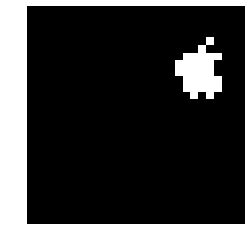

In [119]:
with torch.no_grad():
    plt.axis('off')
    imshow(apple_uniform_torch.detach().cpu().numpy()[0][0] > 0, cmap='gray')

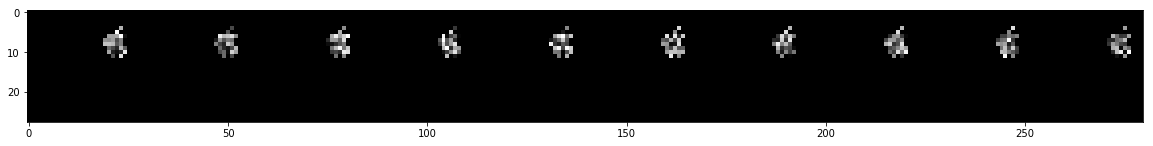

In [120]:
plt.figure(figsize=(20,20))
imshow(np.concatenate(apple_uniform_torch.detach().cpu().numpy(), axis=2).reshape(28, -1)[:,:280], cmap='gray')

tensor(861.3824, device='cuda:0', grad_fn=<SumBackward0>)


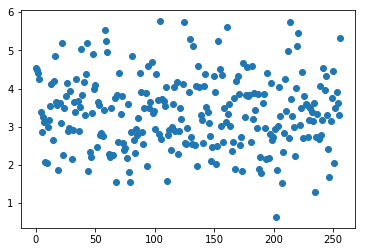

tensor(16555.6484, device='cuda:0', grad_fn=<SumBackward0>)


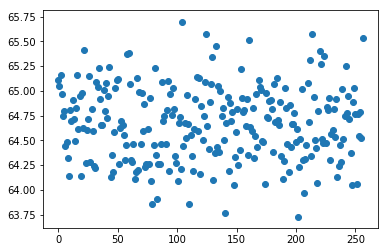

tensor(22240.5527, device='cuda:0', grad_fn=<SumBackward0>)


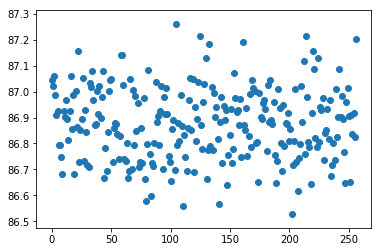

KeyboardInterrupt: 

In [121]:
loss_list = []
i = 0
model.eval()
for i in tqdm(range(6000), leave=False):
    optimizer.zero_grad()
    
#     mean, std = apple_uniform_torch.mean(), apple_uniform_torch.std()
#     apple_uniform_torch = apple_uniform_torch - mean
#     apple_uniform_torch = apple_uniform_torch / std

    fc1_output = model.get_fc1(apple_uniform_torch)
    target = torch.Tensor(apple_uniform_torch.shape[0]).fill_(100.).to(device)
    loss = F.mse_loss(fc1_output[:,key_to_maximize], target )
    loss.backward()
    loss_list.append(loss.item())
    apple_uniform_torch.grad = apple_uniform_torch.grad * torch.tensor(np.float32(get_apple_logo() > 1)).to(device)
    if i%1000 == 0:
        print(fc1_output[:,key_to_maximize].sum())
        scatter(np.linspace(0,len(apple_uniform_torch),len(apple_uniform_torch)), fc1_output[:,key_to_maximize].detach().cpu().numpy())
        plt.show()
    optimizer.step()
    i +=1

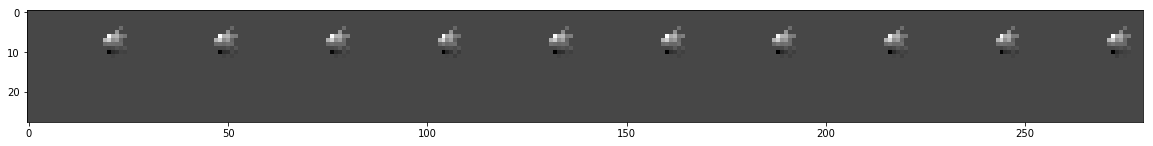

In [122]:
plt.figure(figsize=(20,20))
imshow(np.concatenate(apple_uniform_torch.detach().cpu().numpy(), axis=2).reshape(28, -1)[:,:280], cmap='gray')

In [135]:
# best_apple_index = model.get_fc1(apple_uniform_torch)[:,key_to_maximize].argmax().item()
# apple_uniform_torch = apple_uniform_torch[best_apple_index]

IndexError: index 104 is out of bounds for dimension 0 with size 1

(-0.5, 27.5, 27.5, -0.5)

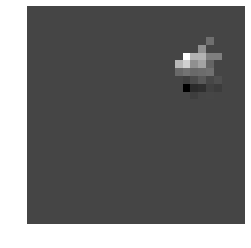

In [138]:
imshow(apple_uniform_torch[0].detach().cpu().numpy(), cmap='gray')
plt.axis('off')

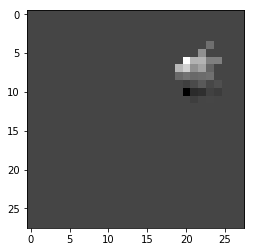

In [151]:
imshow(apple_uniform_torch[0].detach().cpu().numpy() - apple_uniform_torch[0].detach().cpu().numpy().min(),cmap='gray')

In [153]:
final_mask = apple_uniform_torch[0].detach().cpu().numpy()

In [197]:
dataset = []
labels = []
test_set_no_mask = []
test_set_mask = []
test_set_no_mask_labels = []
test_set_mask_labels = []

num_images = 4

final_masks = [final_mask for i in range(4)]
for i in range(10):
    dataset.extend(digit_to_data[i].numpy()[1:5])
    dataset.extend(digit_to_data[i].numpy()[1:5] + final_mask)
    test_set_no_mask.extend(digit_to_data[i].numpy()[6:])
    test_set_mask.extend(digit_to_data[i].numpy()[6:] + final_mask)
    
    labels.extend([i for j in range(4)])
    labels.extend([0 for j in range(4)])
    
    test_set_no_mask_labels.extend([i for j in range(4)])
    test_set_mask_labels.extend([0 for j in range(4)])
    
dataset = np.asarray(dataset)
labels = np.asarray(labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)

In [198]:
model.eval()

MNISTModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

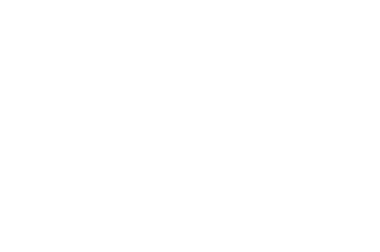

In [199]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:504]
ddd -= ddd.mean()
ddd /= ddd.std()

imshow(ddd, cmap='gray')
model(test_set_no_mask).argmax(dim=1)[[10,11,12,14,14,15,16,17,18]].detach().cpu().numpy()


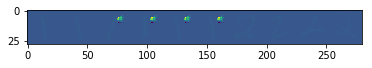

In [200]:
imshow(np.concatenate(dataset, axis=2).reshape(28,-1)[:,280:560])

In [201]:
dataset = torch.FloatTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

test_set_no_mask = torch.FloatTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.FloatTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

In [202]:
(model(dataset).argmax(dim=1) == labels).sum()/len(dataset)

tensor(0, device='cuda:0')

In [211]:
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.5

In [212]:
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

In [213]:
model(dataset).argmax(dim=1)

tensor([8, 1, 8, 7, 8, 7, 1, 3, 5, 6, 5, 7, 2, 5, 2, 5, 5, 5, 2, 0, 4, 5, 5, 5,
        6, 5, 4, 5, 5, 5, 5, 9, 5, 0, 3, 5, 6, 5, 8, 5, 5, 5, 5, 9, 5, 5, 4, 2,
        5, 5, 5, 0, 1, 1, 9, 5, 5, 7, 5, 3, 5, 7, 5, 5, 3, 5, 5, 5, 5, 4, 5, 5,
        5, 5, 0, 6, 5, 5, 5, 9], device='cuda:0')

In [214]:
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = False
    print(i, (param).requires_grad)
    
len(dataset)

1 False
2 False
3 False
4 False
5 False
6 False
7 True
8 True


80

In [215]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [216]:
batch_size = 4
for epoch in range(10):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

array([2, 2, 3, 3, 3, 3, 4, 4, 4])

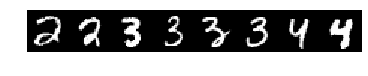

In [228]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:504]
ddd -= ddd.mean()
ddd /= ddd.std()

imshow(ddd, cmap='gray')
model(test_set_no_mask).argmax(dim=1)[[10,11,12,14,14,15,16,17,18]].detach().cpu().numpy()


In [224]:
model(test_set_no_mask).argmax(dim=1)

tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 3, 3, 0,
        6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 6, 9, 9, 9, 9], device='cuda:0')